## Introduction

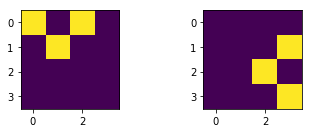

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import pydicom
from pydicom.data import get_testdata_files

# Dataset
A = np.array([[1, 0, 1, 0], [0, 1, 0, 0],[0, 0, 0, 0], [0,0,0,0]], dtype=float)
B = np.array([[0, 0, 0, 0], [0, 0, 0, 2],[0, 0, 2, 0], [0,0,0,2]], dtype=float)

#filename = get_testdata_files("MR_small.dcm")[0]
#dataset = pydicom.read_file(filename)
#A = np.array(dataset.pixel_array, copy=True)
#rollx = 10
#rolly = 0
#B = np.copy(A)
#B = np.roll(B, rollx, axis=0)
#B = np.roll(B, rolly, axis=1)


# Plot images
ax = plt.subplot(2,2,1)
ax.imshow(A)

ax = plt.subplot(2,2,2)
ax.imshow(B)



## Optimization model
Normalized cross correlation ($NCC$). If $A$ is the reference image and $B$ is input image, the object of image registration is to bring the input image into alignment by applying a spartial transformation to the input image,

\begin{equation}
T^* = \underset{T} {\text{arg max}} S\{A,T[B]\}
\end{equation}

$S$ represents the measurement of similarity, $T$ represents the transformation matrix, The aim is to find $S$ similiarity between the images. 

\begin{equation}
T =
\begin{bmatrix}
   \cos{\theta} & -\sin{\theta} & t_x \\
   \sin{\theta} & \cos{\theta} & t_y \\
   0 & 0 & 1
   \end{bmatrix}
\end{equation}

By using $NCC$ similarity and rigid transformation model (which consists of two translation parameters $t_x$ and $t_y$ and one rotation parameter $\theta$) the $NCC$ will look like

\begin{equation}
NCC(A,B) = \dfrac{1}{N} \sum_{(x,y)}{ \dfrac{(A-\mu_A)(B-\mu_B)}{\sigma_A \sigma_B}}
\end{equation}

where $N$ denotes the total number of pixels in image $A$ and $B$, $\mu_A$ and $\mu_B$ denote the average of the images, and $\sigma_A$ and $\sigma_B$ denote the standard deviation. Therefore, the model can be rewritten as

\begin{equation}
T^* = \underset{t_x, t_y, \theta} {\text{arg max}} NCC(A,T(B)) = 
 \dfrac{1}{N} \underset{t_x, t_y, \theta} {\text{arg max}} \sum_{(x,y)}{ \dfrac{(A-\mu_A)(T(B)-\mu_{T(B)})}{\sigma_A \sigma_{T(B)}}}
\end{equation}


In [11]:
def NCC_sum(A, B):
    assert(A.shape == B.shape)
    muA = np.mean(A)
    muB = np.mean(B)
    sigmaA = np.std(A)
    sigmaB = np.std(B)
    #A_vec = np.asarray(A).reshape(-1)
    #B_vec = np.asarray(B).reshape(-1)
    N =  np.size(A)
    return 1/N * np.sum((A-muA)*(B-muB)/(sigmaA*sigmaB))
    #ncc_1 = 1/N * (A_vec-muA).dot((B_vec-muB).T) / (sigmaA * sigmaB)
    #ncc = 0
    #for i in range(N):
    #    ncc = ncc + NCC(A_vec[i], B_vec[i], muA, muB, sigmaA, sigmaB)
    #return ncc / N

def NCC_mat(A, B):
    muA = np.mean(A)
    muB = np.mean(B)
    sigmaA = np.std(A)
    sigmaB = np.std(B)
    return (A-muA)*(B-muB)/(sigmaA*sigmaB)
#def NCC(a, b, muA, muB, sigmaA, sigmaB):    
#    return (a-muA)*(b-muB)/(sigmaA * sigmaB)

print(NCC_mat(A,A))
print(NCC_mat(B,B))
C = np.array([[1,1,1], [1,0,1], [1,1,1]], dtype='float')
print(NCC_mat(C,C))
print(NCC_mat(A,C))

[[0.125 0.125 0.125]
 [0.125 8.    0.125]
 [0.125 0.125 0.125]]
[[0.125 0.125 0.125]
 [0.125 0.125 0.125]
 [0.125 0.125 8.   ]]
[[0.125 0.125 0.125]
 [0.125 8.    0.125]
 [0.125 0.125 0.125]]
[[-0.125 -0.125 -0.125]
 [-0.125 -8.    -0.125]
 [-0.125 -0.125 -0.125]]


## Optimization algorithm

### Firefly algorithm

Nature inspired algorithm based on flashing behaviors of firefly swarm. The primary purpose for the flash is to signal tha attract other fireflies.

Three rules:
1. All fireflies are unisex so that on firefly will be attacted to other fireflies regarding to their sex
2. An important and interesting behavior fo fireflies is to flow brigher mainly to attract pray an the share food with others.
3. Attractiveness is proportinal to their brigthness, thus agent firstly moves toward a neightbor that glows brighter.

The fireflies are randomly distributed in the search space. The fireflies carry a luminescence quality, called liciferin, which emits lighter propotional to quality. Each firefly is attracted by lighter glow of other approximated fireflies. The attractiveness decreases as their distance increases. If there is no brighter one within the scope of a firefly, it will move randomly in the search space. In this application the decision variables are the three spatial tranform parameters $t_x$, $t_y$ and $\theta$. The brightness is associated as the objective function which maximum the $NCC$. The procedure is typed into two phases, variation of light intensit and movement towards attractive flies.

#### Variation of light intensity

\begin{equation}
I_i = f(x_i), 1\leq i \leq n
\end{equation}

#### Movement towards attractive flies

\begin{equation}
\beta_r(i,j) = \beta_0 e^{-\gamma r(i.j)^2}
\end{equation}

\begin{equation}
r(i,j) = \lVert x_i - x_j \rVert
\end{equation}

\begin{equation}
x_i(t+1) = x(t) + \beta_0 e^{-\gamma r^2} (x_j - x_i) + \alpha \epsilon
\end{equation}

Here, $\alpha$ is the parameter controlling the step, and $\epsilon$ is a vector drawn from Gaussian distribution. The classical $FA$ chose $\beta_0 = 1$ (Yang's Comments) and $\alpha$ generated with uniform distribution in range $[0, 1]$   



[0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 2. 0. 0. 0. 0. 2.]
[0. 2. 0. 2. 2. 0. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
[1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


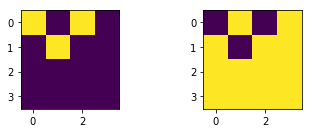

In [46]:
import random

# Initialize 
## Create the initial population of n fireflies within d-dimensional search space
X = np.asarray(np.copy(B)).reshape(-1)
d = len(X)
n = d
A_vec = np.asarray(np.copy(A)).reshape(-1)

## Formulate light intensity of each firefly so as to be associated with the fitness value f(x)
I = NCC_mat(A_vec,X)
I_max = NCC_mat(A_vec, A_vec)
#print(X)
#print(A_vec)
## Define the parameters B_0 and gamma
B0 = 1.0
#r = 0.0
gamma = 0.0

# Perform
criteria = 1
success = False

def UpdateX(xi, xj, B0, r):
    alpha = random.uniform(0,1)
    #epsilon = 0.001
    epsilon = 0
    return xi + B0*np.exp(-gamma*r**2)*(xj-xi)+alpha*epsilon
print(X)
#while success:
for e in range(10):
    for i in range(n): # TODO: This is not only rows
        Ii = I[i]
        for j in range(n): # TODO: This is not only columns
            tempXi = np.copy(X)
            Ij = I[j]
            if Ij < Ii:                
                r = np.sqrt(np.sum(X[i] - X[j])**2)
                xi1 = UpdateX(X[i], X[j], B0, r)
                #print("Updates. x_i: {0}, x_i1: {1}, x_j:{2}, a_i: {3}, lj: {4}, li: {5}".format(X[i], xi1, X[j], A_vec[i], Ij, Ii))
                X[i] = xi1
            I = NCC_mat(A_vec,X)
            #print(I)
    #Rank fireflies and find the current best
print(X)
print(A_vec)
# Plot images
ax = plt.subplot(2,2,1)
ax.imshow(A)

ax = plt.subplot(2,2,2)
ax.imshow(np.asarray(X).reshape(A.shape))

In [18]:
import random
help(random.uniform)
random.uniform(0,1)

Help on method uniform in module random:

uniform(a, b) method of random.Random instance
    Get a random number in the range [a, b) or [a, b] depending on rounding.



0.7123194551734122